# Tutorial: Diseño de Amplificador CS con Metodología gm/ID
## PDK IHP SG13G2 130nm

---

### Objetivos del Tutorial

Al completar este tutorial, serás capaz de:

1. **Entender** la metodología gm/ID para diseño de circuitos analógicos
2. **Usar** tablas de lookup pre-caracterizadas para dimensionar transistores
3. **Analizar** los trade-offs entre velocidad, ganancia y consumo de potencia
4. **Verificar** diseños usando simulación ngspice
5. **Exportar** parámetros para usar en xschem

### Requisitos Previos

- Conocimiento básico de MOSFETs (regiones de operación)
- Python básico
- Familiaridad con xschem (opcional, para la sección final)

---
## Parte 1: Introducción a la Metodología gm/ID

### El Problema: ¿Cómo Dimensionar un Transistor?

Cuando diseñamos un circuito analógico, necesitamos elegir:
- **W** (ancho del transistor)
- **L** (longitud del canal)
- El **punto de operación** (VGS, VDS)

#### Enfoque Clásico (Ecuación Cuadrática)

La ecuación cuadrática del MOSFET en saturación:

$$I_D = \frac{1}{2} \mu C_{ox} \frac{W}{L} (V_{GS} - V_{th})^2$$

**Problemas:**
- Solo válida en inversión fuerte
- Ignora efectos de canal corto
- No funciona bien en inversión moderada/débil

#### Enfoque gm/ID

En lugar de usar la ecuación cuadrática, usamos **datos reales de simulación** organizados en tablas de lookup.

El parámetro clave es **gm/ID** (eficiencia de transconductancia):

$$\frac{g_m}{I_D} = \frac{\partial I_D / \partial V_{GS}}{I_D}$$

Este parámetro es una "perilla de diseño" que controla la región de operación:

| gm/ID (S/A) | Región | Características |
|-------------|--------|----------------|
| 5-10 | Inversión Fuerte | Alta velocidad, alto consumo |
| 10-15 | Inversión Moderada | Balance óptimo |
| 15-25 | Inversión Débil | Bajo consumo, baja velocidad |

---
## Parte 2: Cargando las Tablas de Lookup

Las tablas de lookup contienen parámetros del transistor simulados para múltiples combinaciones de VGS, VDS, VBS y L.

In [1]:
# Importar bibliotecas necesarias
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os

# Widgets para interactividad
import ipywidgets as widgets
from IPython.display import display, HTML, Markdown

# Bibliotecas de mosplot
from mosplot.plot import load_lookup_table, Mosfet, Expression
from mosplot.plot.util import evaluate_expression

# Configuración de gráficos
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100

# Paleta de colores accesible (color-blind friendly)
TOL_BRIGHT = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']
MARKERS = ['o', 's', '^', 'D', 'v', 'p', '*']

print("Bibliotecas cargadas correctamente.")

Bibliotecas cargadas correctamente.


In [2]:
# Cargar la tabla de lookup del NMOS
DATA_DIR = Path("../ihp_sg13g2_data")
nmos_path = DATA_DIR / "sg13_lv_nmos.npz"

if not nmos_path.exists():
    print(f"ERROR: No se encontró el archivo {nmos_path}")
    print("Asegúrate de haber generado las tablas con ihp_lookup_generator.py")
else:
    lt = load_lookup_table(str(nmos_path))
    print(f"Tabla cargada: {nmos_path}")
    print(f"Modelos disponibles: {list(lt.keys())}")

Tabla cargada: ../ihp_sg13g2_data/sg13_lv_nmos.npz
Modelos disponibles: ['sg13_lv_nmos', 'description', 'simulator', 'parameter_names', 'device_parameters']


In [3]:
# Explorar el contenido de la tabla
nmos_data = lt['sg13_lv_nmos']

print("=== Contenido de la Tabla de Lookup ===")
print(f"\nParámetros disponibles:")
for key in nmos_data.keys():
    if isinstance(nmos_data[key], np.ndarray):
        print(f"  {key}: shape = {nmos_data[key].shape}")
    else:
        print(f"  {key}: {nmos_data[key]}")

print(f"\nLongitudes de canal (L):")
print(f"  {[f'{L*1e6:.2f} µm' for L in nmos_data['length']]}")

print(f"\nRango de VGS: {nmos_data['vgs'].min():.2f}V a {nmos_data['vgs'].max():.2f}V")
print(f"Rango de VDS: {nmos_data['vds'].min():.2f}V a {nmos_data['vds'].max():.2f}V")
print(f"Valores de VBS: {nmos_data['vbs']}V")
print(f"\nAncho usado en simulación (W): {nmos_data['width']*1e6:.1f} µm")

=== Contenido de la Tabla de Lookup ===

Parámetros disponibles:
  id: shape = (7, 5, 151, 31)
  gm: shape = (7, 5, 151, 31)
  gds: shape = (7, 5, 151, 31)
  vth: shape = (7, 5, 151, 31)
  cgg: shape = (7, 5, 151, 31)
  cgs: shape = (7, 5, 151, 31)
  cgd: shape = (7, 5, 151, 31)
  vgs: shape = (151,)
  vds: shape = (31,)
  vbs: shape = (5,)
  length: shape = (7,)
  model_name: sg13_lv_nmos
  parameter_names: ['id', 'gm', 'gds', 'vth', 'cgg', 'cgs', 'cgd']
  device_parameters: {'w': 1e-05, 'ng': 1, 'm': 1}

Longitudes de canal (L):
  ['0.13 µm', '0.15 µm', '0.18 µm', '0.25 µm', '0.50 µm', '1.00 µm', '2.00 µm']

Rango de VGS: 0.00V a 1.50V
Rango de VDS: 0.00V a 1.50V
Valores de VBS: [ 0.  -0.3 -0.6 -0.9 -1.2]V


KeyError: 'width'

---
## Parte 3: Las 4 Gráficas Fundamentales

La metodología gm/ID usa 4 gráficas clave para el diseño. Veamos cada una y qué nos dice.

In [4]:
# Crear objeto Mosfet para análisis
# Fijamos VDS = 0.6V (saturación) y VBS = 0V
nmos = Mosfet(
    lookup_table=lt,
    mos="sg13_lv_nmos",
    vbs=0.0,
    vds=0.6,
    vgs=(0.3, 1.2)  # Rango de VGS a analizar
)

print(f"Mosfet configurado:")
print(f"  VDS = 0.6V (fijo)")
print(f"  VBS = 0.0V (fijo)")
print(f"  VGS = 0.3V a 1.2V (barrido)")
print(f"  Longitudes: {[f'{L*1e6:.2f}µm' for L in nmos.length]}")

Mosfet configurado:
  VDS = 0.6V (fijo)
  VBS = 0.0V (fijo)
  VGS = 0.3V a 1.2V (barrido)
  Longitudes: ['0.13µm', '0.15µm', '0.18µm', '0.25µm', '0.50µm', '1.00µm', '2.00µm']


In [5]:
# Extraer datos para las gráficas
gmid_data, _ = evaluate_expression(nmos.gmid_expression, nmos.extracted_table)
gain_data, _ = evaluate_expression(nmos.gain_expression, nmos.extracted_table)
ft_data, _ = evaluate_expression(nmos.transist_frequency_expression, nmos.extracted_table)
id_w_data, _ = evaluate_expression(nmos.current_density_expression, nmos.extracted_table)

print(f"Datos extraídos: {gmid_data.shape[0]} longitudes × {gmid_data.shape[1]} puntos de VGS")

Datos extraídos: 7 longitudes × 91 puntos de VGS


### Gráfica 1: Frecuencia de Tránsito (fT) vs gm/ID

**¿Qué muestra?** La velocidad máxima del transistor.

**Observación clave:** fT disminuye al aumentar gm/ID. Esto significa que operar en inversión débil (alto gm/ID) reduce la velocidad.

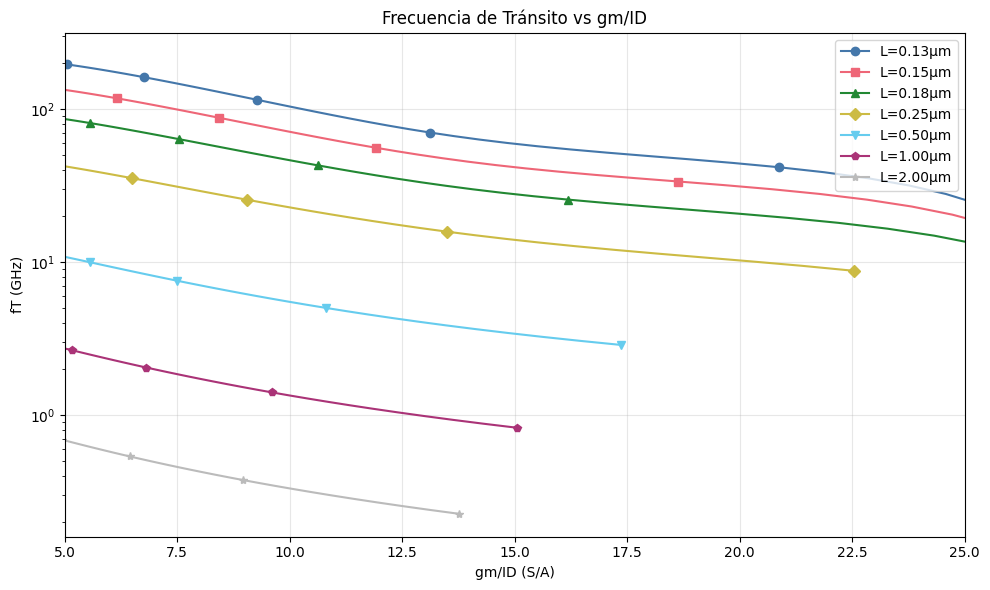

💡 Observa: Las longitudes más cortas tienen mayor fT (son más rápidas)


In [7]:
fig, ax = plt.subplots()

for l_idx, L in enumerate(nmos.length):
    valid = np.isfinite(gmid_data[l_idx, :]) & (ft_data[l_idx, :] > 0)
    ax.semilogy(
        gmid_data[l_idx, valid], ft_data[l_idx, valid] / 1e9,
        color=TOL_BRIGHT[l_idx % len(TOL_BRIGHT)],
        marker=MARKERS[l_idx % len(MARKERS)],
        markevery=10,
        label=f'L={L*1e6:.2f}µm'
    )

ax.set_xlabel('gm/ID (S/A)')
ax.set_ylabel('fT (GHz)')
ax.set_title('Frecuencia de Tránsito vs gm/ID')
ax.set_xlim(5, 25)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("💡 Observa: Las longitudes más cortas tienen mayor fT (son más rápidas)")

### Gráfica 2: Ganancia Intrínseca (gm/gds) vs gm/ID

**¿Qué muestra?** La ganancia máxima que puede dar el transistor (sin carga).

**Observación clave:** La ganancia aumenta con L y con gm/ID.

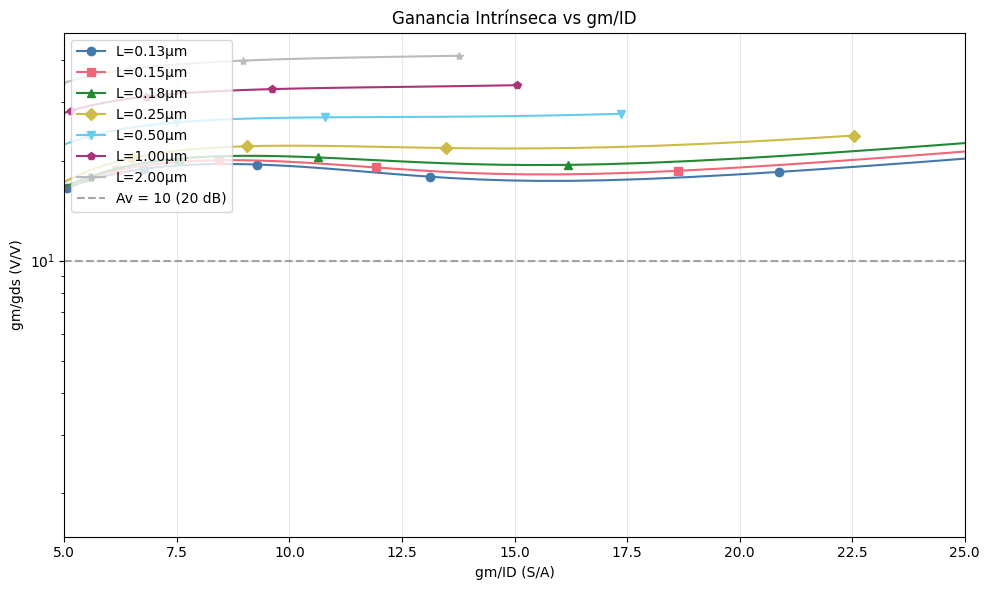

💡 Observa: Las longitudes más largas tienen mayor ganancia (menor gds)


In [8]:
fig, ax = plt.subplots()

for l_idx, L in enumerate(nmos.length):
    valid = np.isfinite(gmid_data[l_idx, :]) & (gain_data[l_idx, :] > 0)
    ax.semilogy(
        gmid_data[l_idx, valid], gain_data[l_idx, valid],
        color=TOL_BRIGHT[l_idx % len(TOL_BRIGHT)],
        marker=MARKERS[l_idx % len(MARKERS)],
        markevery=10,
        label=f'L={L*1e6:.2f}µm'
    )

# Línea de referencia: Ganancia = 10 (20 dB)
ax.axhline(y=10, color='gray', linestyle='--', alpha=0.7, label='Av = 10 (20 dB)')

ax.set_xlabel('gm/ID (S/A)')
ax.set_ylabel('gm/gds (V/V)')
ax.set_title('Ganancia Intrínseca vs gm/ID')
ax.set_xlim(5, 25)
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("💡 Observa: Las longitudes más largas tienen mayor ganancia (menor gds)")

### Gráfica 3: Densidad de Corriente (ID/W) vs gm/ID

**¿Qué muestra?** Cuánta corriente fluye por unidad de ancho.

**Uso principal:** Para calcular W una vez que conocemos ID.

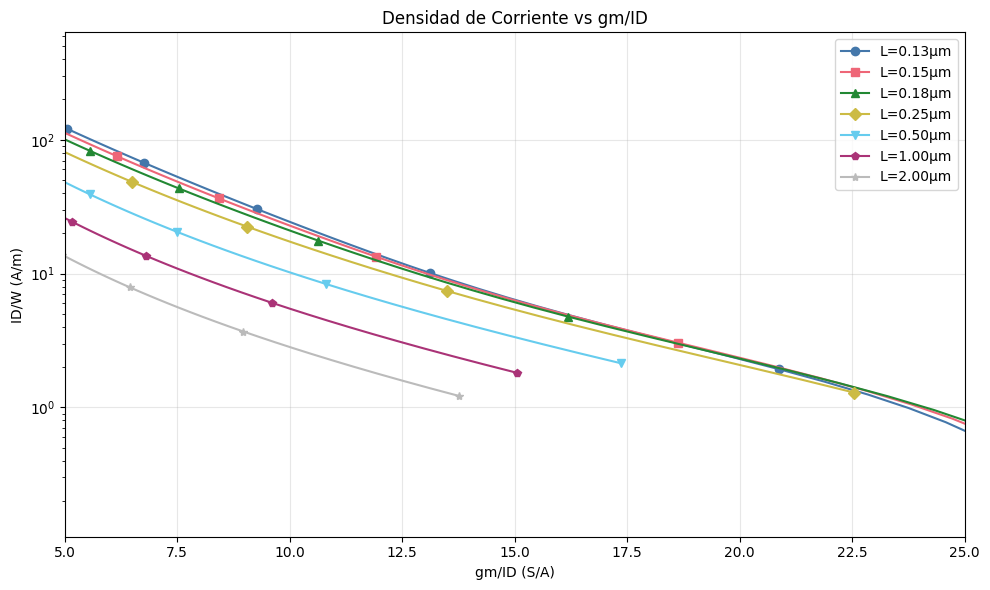

💡 Esta gráfica te permite calcular: W = ID / (ID/W)


In [9]:
fig, ax = plt.subplots()

for l_idx, L in enumerate(nmos.length):
    valid = np.isfinite(gmid_data[l_idx, :]) & (id_w_data[l_idx, :] > 0)
    ax.semilogy(
        gmid_data[l_idx, valid], id_w_data[l_idx, valid],
        color=TOL_BRIGHT[l_idx % len(TOL_BRIGHT)],
        marker=MARKERS[l_idx % len(MARKERS)],
        markevery=10,
        label=f'L={L*1e6:.2f}µm'
    )

ax.set_xlabel('gm/ID (S/A)')
ax.set_ylabel('ID/W (A/m)')
ax.set_title('Densidad de Corriente vs gm/ID')
ax.set_xlim(5, 25)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("💡 Esta gráfica te permite calcular: W = ID / (ID/W)")

---
## Parte 4: Diseño Interactivo Paso a Paso

Ahora vamos a diseñar un amplificador de fuente común. Usa los controles interactivos para experimentar con diferentes valores.

In [10]:
# === ESPECIFICACIONES DE DISEÑO ===
# Modifica estos valores para experimentar

VDD = 1.2           # Voltaje de alimentación (V)
Av_target = 10.0    # Ganancia objetivo (V/V) - 20 dB
BW_target = 100e6   # Ancho de banda objetivo (Hz) - 100 MHz
CL = 100e-15        # Capacitancia de carga (F) - 100 fF
VDS_op = 0.6        # VDS de operación (V)

print("=== Especificaciones de Diseño ===")
print(f"  VDD = {VDD} V")
print(f"  Ganancia objetivo (Av) = {Av_target} V/V ({20*np.log10(Av_target):.1f} dB)")
print(f"  Ancho de banda (BW) = {BW_target/1e6:.0f} MHz")
print(f"  Capacitancia de carga (CL) = {CL*1e15:.0f} fF")

=== Especificaciones de Diseño ===
  VDD = 1.2 V
  Ganancia objetivo (Av) = 10.0 V/V (20.0 dB)
  Ancho de banda (BW) = 100 MHz
  Capacitancia de carga (CL) = 100 fF


### Paso 1: Calcular gm Requerida

Para un amplificador con carga capacitiva, el ancho de banda está dado por:

$$BW = \frac{g_m}{2\pi C_L}$$

Despejando gm:

$$g_m = 2\pi \cdot BW \cdot C_L$$

In [11]:
# PASO 1: Calcular gm requerida
gm_required = 2 * np.pi * BW_target * CL

print(f"=== PASO 1: gm Requerida ===")
print(f"  gm = 2π × {BW_target/1e6:.0f} MHz × {CL*1e15:.0f} fF")
print(f"  gm = {gm_required*1e6:.2f} µS")

=== PASO 1: gm Requerida ===
  gm = 2π × 100 MHz × 100 fF
  gm = 62.83 µS


### Paso 2: Seleccionar Longitud de Canal (L)

Usa el control deslizante para seleccionar L y observa si cumple con el requisito de ganancia.

In [13]:
# Widget para seleccionar L
L_options = {f'{L*1e6:.2f} µm': L for L in nmos.length}

L_dropdown = widgets.Dropdown(
    options=L_options,
    value=nmos.length[2],  # Valor inicial: 0.18 µm
    description='Longitud L:',
    style={'description_width': 'initial'}
)

output_L = widgets.Output()

def update_L_plot(change):
    with output_L:
        output_L.clear_output(wait=True)
        L_selected = change['new']
        L_idx = np.argmin(np.abs(np.array(nmos.length) - L_selected))
        
        fig, ax = plt.subplots(figsize=(10, 5))
        
        # Graficar todas las longitudes en gris
        for l_idx, L in enumerate(nmos.length):
            valid = np.isfinite(gmid_data[l_idx, :]) & (gain_data[l_idx, :] > 0)
            ax.semilogy(gmid_data[l_idx, valid], gain_data[l_idx, valid],
                       color='lightgray', alpha=0.5)
        
        # Resaltar la longitud seleccionada
        valid = np.isfinite(gmid_data[L_idx, :]) & (gain_data[L_idx, :] > 0)
        ax.semilogy(gmid_data[L_idx, valid], gain_data[L_idx, valid],
                   color=TOL_BRIGHT[0], linewidth=3,
                   label=f'L = {L_selected*1e6:.2f} µm (SELECCIONADO)')
        
        # Línea de ganancia objetivo
        ax.axhline(y=Av_target, color='red', linestyle='--', 
                   label=f'Objetivo: Av = {Av_target} V/V')
        
        ax.set_xlabel('gm/ID (S/A)')
        ax.set_ylabel('Ganancia (V/V)')
        ax.set_title('Selección de L para Cumplir Ganancia')
        ax.set_xlim(5, 25)
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Verificar si cumple
        max_gain = np.max(gain_data[L_idx, valid])
        gain_at_10 = gain_data[L_idx, np.argmin(np.abs(gmid_data[L_idx, :] - 10))]
        
        if gain_at_10 >= Av_target:
            print(f"✅ L = {L_selected*1e6:.2f} µm CUMPLE el requisito")
        else:
            print(f"❌ L = {L_selected*1e6:.2f} µm NO CUMPLE - considera usar L más grande")
        print(f"   Ganancia @ gm/ID=10: {gain_at_10:.1f} V/V ({20*np.log10(gain_at_10):.1f} dB)")
        print(f"   Ganancia máxima: {max_gain:.1f} V/V ({20*np.log10(max_gain):.1f} dB)")

L_dropdown.observe(update_L_plot, names='value')
display(L_dropdown)
display(output_L)

# Trigger inicial
update_L_plot({'new': L_dropdown.value})

Dropdown(description='Longitud L:', index=2, options={'0.13 µm': np.float64(1.3e-07), '0.15 µm': np.float64(1.…

Output()

### Paso 3: Seleccionar gm/ID de Operación

El valor de gm/ID controla:
- **Bajo gm/ID (5-10)**: Inversión fuerte, alta velocidad, alto consumo
- **Alto gm/ID (15-20)**: Inversión débil, baja velocidad, bajo consumo

In [16]:
# Widgets para diseño interactivo
gmid_slider = widgets.FloatSlider(
    value=10.0,
    min=5.0,
    max=20.0,
    step=0.5,
    description='gm/ID (S/A):',
    continuous_update=True,
    style={'description_width': 'initial'}
)

output_design = widgets.Output()

def update_design(change):
    with output_design:
        output_design.clear_output(wait=True)
        
        gmid_target = gmid_slider.value
        L_selected = L_dropdown.value
        L_idx = np.argmin(np.abs(np.array(nmos.length) - L_selected))
        
        # Encontrar punto más cercano al gm/ID objetivo
        valid = np.isfinite(gmid_data[L_idx, :]) & (gmid_data[L_idx, :] > 0)
        valid_indices = np.where(valid)[0]
        closest_idx = valid_indices[np.argmin(np.abs(gmid_data[L_idx, valid] - gmid_target))]
        
        # Extraer valores en el punto de operación
        gmid_op = gmid_data[L_idx, closest_idx]
        gain_op = gain_data[L_idx, closest_idx]
        ft_op = ft_data[L_idx, closest_idx]
        id_w_op = id_w_data[L_idx, closest_idx]
        vgs_op = nmos.vgs[closest_idx]
        
        # Calcular dimensiones
        id_required = gm_required / gmid_op
        w_required = id_required / id_w_op
        
        # Crear visualización
        fig, axes = plt.subplots(1, 3, figsize=(14, 4))
        
        # Plot 1: Ganancia
        ax = axes[0]
        valid_plot = np.isfinite(gmid_data[L_idx, :]) & (gain_data[L_idx, :] > 0)
        ax.semilogy(gmid_data[L_idx, valid_plot], gain_data[L_idx, valid_plot], 
                   color=TOL_BRIGHT[0], linewidth=2)
        ax.plot(gmid_op, gain_op, 'r*', markersize=15, label='Punto de operación')
        ax.axhline(y=Av_target, color='gray', linestyle='--', alpha=0.7)
        ax.set_xlabel('gm/ID (S/A)')
        ax.set_ylabel('Ganancia (V/V)')
        ax.set_title('Ganancia')
        ax.set_xlim(5, 20)
        ax.grid(True, alpha=0.3)
        
        # Plot 2: fT
        ax = axes[1]
        valid_plot = np.isfinite(gmid_data[L_idx, :]) & (ft_data[L_idx, :] > 0)
        ax.semilogy(gmid_data[L_idx, valid_plot], ft_data[L_idx, valid_plot]/1e9, 
                   color=TOL_BRIGHT[1], linewidth=2)
        ax.plot(gmid_op, ft_op/1e9, 'r*', markersize=15)
        ax.axhline(y=BW_target/1e9, color='gray', linestyle='--', alpha=0.7)
        ax.set_xlabel('gm/ID (S/A)')
        ax.set_ylabel('fT (GHz)')
        ax.set_title('Velocidad (fT)')
        ax.set_xlim(5, 20)
        ax.grid(True, alpha=0.3)
        
        # Plot 3: ID/W
        ax = axes[2]
        valid_plot = np.isfinite(gmid_data[L_idx, :]) & (id_w_data[L_idx, :] > 0)
        ax.semilogy(gmid_data[L_idx, valid_plot], id_w_data[L_idx, valid_plot], 
                   color=TOL_BRIGHT[2], linewidth=2)
        ax.plot(gmid_op, id_w_op, 'r*', markersize=15)
        ax.set_xlabel('gm/ID (S/A)')
        ax.set_ylabel('ID/W (A/m)')
        ax.set_title('Densidad de Corriente')
        ax.set_xlim(5, 20)
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Mostrar resultados
        print("=" * 50)
        print("RESULTADOS DEL DISEÑO")
        print("=" * 50)
        print(f"\n📐 PARÁMETROS SELECCIONADOS:")
        print(f"   L = {L_selected*1e6:.3f} µm")
        print(f"   gm/ID = {gmid_op:.2f} S/A")
        print(f"   VGS = {vgs_op:.3f} V")
        
        print(f"\n📊 DIMENSIONES CALCULADAS:")
        print(f"   W = {w_required*1e6:.3f} µm")
        print(f"   ID = {id_required*1e6:.3f} µA")
        print(f"   gm = {gm_required*1e6:.3f} µS")
        
        print(f"\n🎯 VERIFICACIÓN DE ESPECIFICACIONES:")
        gain_check = "✅" if gain_op >= Av_target else "❌"
        ft_check = "✅" if ft_op >= BW_target else "❌"
        print(f"   {gain_check} Ganancia: {gain_op:.1f} V/V ({20*np.log10(gain_op):.1f} dB) [objetivo: {Av_target} V/V]")
        print(f"   {ft_check} fT: {ft_op/1e9:.1f} GHz [margen sobre BW: {ft_op/BW_target:.0f}x]")
        print(f"   Potencia: {VDD * id_required * 1e6:.2f} µW")

gmid_slider.observe(update_design, names='value')
L_dropdown.observe(update_design, names='value')

display(widgets.VBox([L_dropdown, gmid_slider]))
display(output_design)

# Trigger inicial
update_design({'new': gmid_slider.value})

Output()

---
## Parte 5: Verificación con Ngspice

Vamos a verificar el diseño simulando con ngspice.

In [17]:
# Función para generar netlist
def generate_netlist(W, L, VGS, VDS=0.6):
    """Genera un netlist de ngspice para verificación del punto de operación."""
    
    pdk_root = os.environ.get('PDK_ROOT', '/path/to/IHP-Open-PDK')
    lib_path = f"{pdk_root}/ihp-sg13g2/libs.tech/ngspice/models/cornerMOSlv.lib"
    
    netlist = f"""* CS Amplifier - Operating Point Verification
* Generated from gm/ID Tutorial

.param W_DESIGN = {W:.6e}
.param L_DESIGN = {L:.6e}
.param VGS_OP = {VGS:.4f}
.param VDS_OP = {VDS:.2f}

.lib '{lib_path}' mos_tt

VGS gate 0 DC={{VGS_OP}}
VDS drain 0 DC={{VDS_OP}}

X1 drain gate 0 0 sg13_lv_nmos L={{L_DESIGN}} W={{W_DESIGN}} ng=1 m=1

.op

.control
op
print @n.x1.nsg13_lv_nmos[id]
print @n.x1.nsg13_lv_nmos[gm]
print @n.x1.nsg13_lv_nmos[gds]
print @n.x1.nsg13_lv_nmos[vth]
.endc

.end
"""
    return netlist

# Obtener valores actuales del diseño
L_selected = L_dropdown.value
L_idx = np.argmin(np.abs(np.array(nmos.length) - L_selected))
gmid_target = gmid_slider.value

valid = np.isfinite(gmid_data[L_idx, :]) & (gmid_data[L_idx, :] > 0)
valid_indices = np.where(valid)[0]
closest_idx = valid_indices[np.argmin(np.abs(gmid_data[L_idx, valid] - gmid_target))]

gmid_op = gmid_data[L_idx, closest_idx]
id_w_op = id_w_data[L_idx, closest_idx]
vgs_op = nmos.vgs[closest_idx]
id_required = gm_required / gmid_op
w_required = id_required / id_w_op

# Generar y mostrar netlist
netlist = generate_netlist(w_required, L_selected, vgs_op)
print("=== NETLIST GENERADO ===")
print(netlist)

=== NETLIST GENERADO ===
* CS Amplifier - Operating Point Verification
* Generated from gm/ID Tutorial

.param W_DESIGN = 2.526345e-07
.param L_DESIGN = 1.300000e-07
.param VGS_OP = 0.5800
.param VDS_OP = 0.60

.lib '/home/montanares/git/ihp_pdk/IHP-Open-PDK/ihp-sg13g2/libs.tech/ngspice/models/cornerMOSlv.lib' mos_tt

VGS gate 0 DC={VGS_OP}
VDS drain 0 DC={VDS_OP}

X1 drain gate 0 0 sg13_lv_nmos L={L_DESIGN} W={W_DESIGN} ng=1 m=1

.op

.control
op
print @n.x1.nsg13_lv_nmos[id]
print @n.x1.nsg13_lv_nmos[gm]
print @n.x1.nsg13_lv_nmos[gds]
print @n.x1.nsg13_lv_nmos[vth]
.endc

.end



In [18]:
# Guardar y ejecutar simulación
import subprocess
import tempfile
import re

def run_ngspice_op(netlist):
    """Ejecuta ngspice y extrae resultados del .op"""
    
    with tempfile.NamedTemporaryFile(mode='w', suffix='.cir', delete=False) as f:
        f.write(netlist)
        netlist_path = f.name
    
    try:
        result = subprocess.run(
            ['ngspice', '-b', netlist_path],
            capture_output=True,
            text=True,
            timeout=30
        )
        output = result.stdout + result.stderr
        
        # Parsear resultados
        results = {}
        patterns = {
            'id': r'\[id\]\s*=\s*([\d.e+-]+)',
            'gm': r'\[gm\]\s*=\s*([\d.e+-]+)',
            'gds': r'\[gds\]\s*=\s*([\d.e+-]+)',
            'vth': r'\[vth\]\s*=\s*([\d.e+-]+)'
        }
        
        for param, pattern in patterns.items():
            match = re.search(pattern, output)
            if match:
                results[param] = float(match.group(1))
        
        return results, output
        
    except subprocess.TimeoutExpired:
        return None, "Timeout: La simulación tardó demasiado"
    except FileNotFoundError:
        return None, "Error: ngspice no encontrado. Verifica que esté instalado."
    finally:
        os.unlink(netlist_path)

print("Ejecutando simulación ngspice...")
sim_results, sim_output = run_ngspice_op(netlist)

if sim_results:
    print("\n=== RESULTADOS DE SIMULACIÓN ===")
    print(f"  ID  = {sim_results.get('id', 0)*1e6:.3f} µA")
    print(f"  gm  = {sim_results.get('gm', 0)*1e6:.3f} µS")
    print(f"  gds = {sim_results.get('gds', 0)*1e6:.3f} µS")
    print(f"  Vth = {sim_results.get('vth', 0):.3f} V")
    
    if 'gm' in sim_results and 'id' in sim_results:
        gmid_sim = sim_results['gm'] / sim_results['id']
        print(f"  gm/ID = {gmid_sim:.2f} S/A")
    
    if 'gm' in sim_results and 'gds' in sim_results:
        gain_sim = sim_results['gm'] / sim_results['gds']
        print(f"  Ganancia = {gain_sim:.1f} V/V ({20*np.log10(gain_sim):.1f} dB)")
else:
    print(f"\n⚠️  No se pudo ejecutar la simulación:")
    print(sim_output[:500])

Ejecutando simulación ngspice...

=== RESULTADOS DE SIMULACIÓN ===
  ID  = 0.000 µA
  gm  = 40.475 µS
  gds = 2.231 µS
  Vth = 0.454 V
  Ganancia = 18.1 V/V (25.2 dB)


---
## Parte 6: Ejercicios de Experimentación

Ahora es tu turno de experimentar. Modifica los parámetros y observa los efectos.

### Ejercicio 1: Aumentar el Ancho de Banda a 200 MHz

**Pregunta:** Si necesitas BW = 200 MHz (el doble), ¿qué cambia en el diseño?

**Instrucciones:**
1. Modifica `BW_target = 200e6` en la celda de especificaciones
2. Re-ejecuta las celdas de diseño
3. Observa cómo cambian W e ID

In [19]:
# Tu código aquí - Experimenta con BW = 200 MHz
BW_exercise = 200e6  # Modifica este valor
gm_exercise = 2 * np.pi * BW_exercise * CL

print(f"Con BW = {BW_exercise/1e6:.0f} MHz:")
print(f"  gm requerida = {gm_exercise*1e6:.2f} µS (antes: {gm_required*1e6:.2f} µS)")
print(f"  Incremento: {gm_exercise/gm_required:.1f}x")

Con BW = 200 MHz:
  gm requerida = 125.66 µS (antes: 62.83 µS)
  Incremento: 2.0x


### Ejercicio 2: Conseguir Mayor Ganancia (30 dB)

**Pregunta:** Si necesitas Av = 30 dB (~32 V/V), ¿qué longitud L debes usar?

**Instrucciones:**
1. Observa la gráfica de Ganancia vs gm/ID
2. Encuentra qué L proporciona ganancia > 32 V/V
3. Considera el impacto en fT

In [20]:
# Análisis para ejercicio 2
Av_target_30dB = 10**(30/20)  # ~31.6 V/V

print(f"Ganancia objetivo: {Av_target_30dB:.1f} V/V (30 dB)\n")
print("Ganancia máxima por longitud (@ gm/ID=10):")
print("-" * 40)

for l_idx, L in enumerate(nmos.length):
    valid = np.isfinite(gmid_data[l_idx, :]) & (gain_data[l_idx, :] > 0)
    idx_10 = np.argmin(np.abs(gmid_data[l_idx, valid] - 10))
    gain_at_10 = gain_data[l_idx, valid][idx_10]
    ft_at_10 = ft_data[l_idx, valid][idx_10]
    
    check = "✅" if gain_at_10 >= Av_target_30dB else "  "
    print(f"{check} L = {L*1e6:.2f} µm: Av = {gain_at_10:.1f} V/V, fT = {ft_at_10/1e9:.1f} GHz")

Ganancia objetivo: 31.6 V/V (30 dB)

Ganancia máxima por longitud (@ gm/ID=10):
----------------------------------------
   L = 0.13 µm: Av = 19.3 V/V, fT = 105.8 GHz
   L = 0.15 µm: Av = 19.8 V/V, fT = 71.7 GHz
   L = 0.18 µm: Av = 20.6 V/V, fT = 47.1 GHz
   L = 0.25 µm: Av = 22.2 V/V, fT = 22.5 GHz
   L = 0.50 µm: Av = 26.9 V/V, fT = 5.5 GHz
✅ L = 1.00 µm: Av = 32.9 V/V, fT = 1.3 GHz
✅ L = 2.00 µm: Av = 40.4 V/V, fT = 0.3 GHz


### Ejercicio 3: Trade-off Velocidad vs Consumo

Compara dos diseños:
- **Diseño A:** gm/ID = 8 (inversión fuerte, rápido)
- **Diseño B:** gm/ID = 15 (inversión moderada/débil, bajo consumo)

In [21]:
# Comparación de dos puntos de operación
L_fixed = 0.18e-6  # Usar L = 0.18 µm para ambos
L_idx = np.argmin(np.abs(np.array(nmos.length) - L_fixed))

def get_design_point(gmid_target):
    valid = np.isfinite(gmid_data[L_idx, :]) & (gmid_data[L_idx, :] > 0)
    valid_indices = np.where(valid)[0]
    closest_idx = valid_indices[np.argmin(np.abs(gmid_data[L_idx, valid] - gmid_target))]
    
    gmid_op = gmid_data[L_idx, closest_idx]
    gain_op = gain_data[L_idx, closest_idx]
    ft_op = ft_data[L_idx, closest_idx]
    id_w_op = id_w_data[L_idx, closest_idx]
    
    id_req = gm_required / gmid_op
    w_req = id_req / id_w_op
    power = VDD * id_req
    
    return {
        'gmid': gmid_op,
        'gain': gain_op,
        'ft': ft_op,
        'id': id_req,
        'w': w_req,
        'power': power
    }

design_A = get_design_point(8)
design_B = get_design_point(15)

print(f"{'Parámetro':<20} {'Diseño A (gm/ID=8)':<25} {'Diseño B (gm/ID=15)':<25}")
print("=" * 70)
print(f"{'gm/ID (S/A)':<20} {design_A['gmid']:<25.2f} {design_B['gmid']:<25.2f}")
print(f"{'Ganancia (V/V)':<20} {design_A['gain']:<25.1f} {design_B['gain']:<25.1f}")
print(f"{'fT (GHz)':<20} {design_A['ft']/1e9:<25.1f} {design_B['ft']/1e9:<25.1f}")
print(f"{'ID (µA)':<20} {design_A['id']*1e6:<25.3f} {design_B['id']*1e6:<25.3f}")
print(f"{'W (µm)':<20} {design_A['w']*1e6:<25.3f} {design_B['w']*1e6:<25.3f}")
print(f"{'Potencia (µW)':<20} {design_A['power']*1e6:<25.2f} {design_B['power']*1e6:<25.2f}")
print("\n💡 Observa: El Diseño B consume menos potencia pero tiene menor fT")

Parámetro            Diseño A (gm/ID=8)        Diseño B (gm/ID=15)      
gm/ID (S/A)          8.05                      14.71                    
Ganancia (V/V)       20.5                      19.4                     
fT (GHz)             59.8                      28.5                     
ID (µA)              7.808                     4.271                    
W (µm)               0.211                     0.657                    
Potencia (µW)        9.37                      5.12                     

💡 Observa: El Diseño B consume menos potencia pero tiene menor fT


---
## Parte 7: Exportación para xschem

Finalmente, exportamos los parámetros para usar en xschem.

In [ ]:
# Obtener valores finales del diseño
L_final = L_dropdown.value
L_idx = np.argmin(np.abs(np.array(nmos.length) - L_final))
gmid_final = gmid_slider.value

valid = np.isfinite(gmid_data[L_idx, :]) & (gmid_data[L_idx, :] > 0)
valid_indices = np.where(valid)[0]
closest_idx = valid_indices[np.argmin(np.abs(gmid_data[L_idx, valid] - gmid_final))]

gmid_op = gmid_data[L_idx, closest_idx]
id_w_op = id_w_data[L_idx, closest_idx]
vgs_op = nmos.vgs[closest_idx]
id_final = gm_required / gmid_op
w_final = id_final / id_w_op

print("="*60)
print("PARÁMETROS PARA XSCHEM")
print("="*60)
print(f"""
Símbolo: sg13_lv_nmos (IHP SG13G2 LV NMOS)

Propiedades del componente:
  model = sg13_lv_nmos
  W = {w_final*1e6:.3f}u
  L = {L_final*1e6:.3f}u
  ng = 1
  m = 1

Punto de operación esperado:
  VGS = {vgs_op:.3f} V
  VDS = {VDS_op:.2f} V
  ID  = {id_final*1e6:.3f} µA
  gm  = {gm_required*1e6:.3f} µS
""")

print("\n📋 Copia estos valores a xschem al crear tu esquemático.")
print("   El símbolo sg13_lv_nmos está en:")
print("   $PDK_ROOT/ihp-sg13g2/libs.tech/xschem/sg13g2_pr/")

---
## Resumen

En este tutorial aprendiste:

1. **Metodología gm/ID**: Usar tablas de lookup en lugar de ecuaciones simplificadas
2. **Las 4 gráficas fundamentales**: fT, ganancia, ID/W, gm/W vs gm/ID
3. **Proceso de diseño**:
   - Calcular gm requerida desde BW y CL
   - Seleccionar L para cumplir ganancia
   - Seleccionar gm/ID balanceando trade-offs
   - Calcular W e ID
4. **Verificación**: Usar ngspice para validar el diseño
5. **Exportación**: Parámetros listos para xschem

### Próximos Pasos

- Crear el esquemático en xschem
- Simular el amplificador completo (con carga y fuente de corriente)
- Analizar respuesta en frecuencia (.ac)
- Explorar otros bloques: par diferencial, espejo de corriente